In [1]:
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
edt = np.load('results/edt.npy')
nt,nx,ny = edt.shape

In [3]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

448 440
(406, 960, 952)


In [4]:
print(crop_edt.shape)
crop_edt = crop_edt[:,::16,::16]
print(crop_edt.shape)
nt,nx,ny = crop_edt.shape

(406, 960, 952)
(406, 60, 60)


In [5]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx):
    du = np.zeros((nx,ny))
    du[tmask] += phi * (t < 6 * 60 * 60) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    du[tmask] -= gamma * u[tmask] * (t < 6 * 60 * 60)
    return du.ravel()

In [15]:
from scipy.integrate import odeint

t = np.linspace(0, 40 * 60 * 60, 200)
phi = 0
kappa = 5e-14
gamma = 1e-2
dx = 16e-6
#u = odeint(dudt, u0.ravel(), t, args=(crop_edt>0,phi,kappa,gamma,dx))
dt = 30
ts = np.arange(0, np.floor(48 * 60 * 60 // dt))
nt = len(ts)
print(nt)
u = np.zeros((nt+1,nx,ny))
u[0,:,:] = u0
mask = np.zeros((nt+1,nx,ny))
mask[0,:,:] = crop_edt[0,:,:]>0
for ti in range(nt):
    t = int(ts[ti] * dt)
    tmask = crop_edt[int(t / 60 / 10),:,:]
    du = dudt(u[ti,:,:], t, tmask>0,phi,kappa,gamma,dx)
    u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
    mask[ti+1,:,:] = tmask
#u = u.reshape((200,nx,ny))

5760


In [16]:
umask = np.zeros_like(u) + np.nan
umask[mask>0] = u[mask>0]

KeyboardInterrupt: 

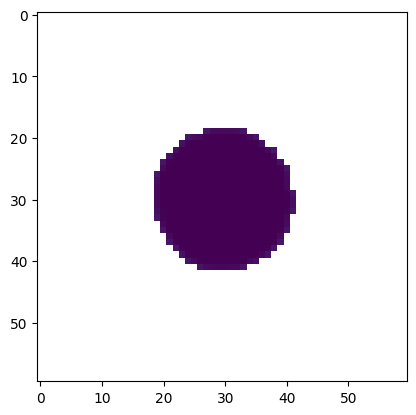

In [108]:
for ti in range(nt//30):
    plt.imshow(umask[ti*30,:,:], vmin=0, vmax=np.nanmax(u))
    plt.savefig('umask_%04d.png'%ti)

/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_21217/2037360058.py:3: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contour(u[:,int(nx//2),:].transpose(), [0.025,0.05,0.075], linestyle='w--')


Text(0, 0.5, 'Position (pixels)')

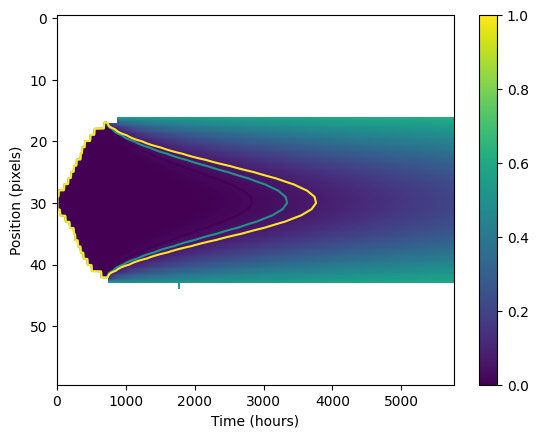

In [17]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
plt.contour(u[:,int(nx//2),:].transpose(), [0.025,0.05,0.075], linestyle='w--')
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')